In [1]:
import numpy as np
import pandas as pd
import scipy.integrate
import scipy.optimize
import scipy.stats
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings('ignore')


legfont=16
plt.rc("xtick", labelsize=legfont)
plt.rc("ytick", labelsize=legfont)

FMGEV=5.068

# no analytical solution for the deformed nucleus (using the one for the spherical nuclei)
def Norm(R, a):
    return (3/(4.0 * np.pi * R**3)) * (1/(1.0 + (np.pi * a/R)**2))

def integrand(z, b, R):
    a=0.55* FMGEV
    return Norm(R, a)/(np.exp((np.sqrt(b**2+z**2) - R)/a) + 1)

"""FIT AS A FUNCTION OF R(THETA) AND THEN DO A LINEAR FIT FOR THE DEFORAMTION PARAMETER"""
def func(b, R):
    return scipy.integrate.quad(integrand, -np.inf, np.inf, args=(b, R))[0]


In [10]:
dir_='Fluctuatingx0_U_roots70/MoreStat/Fluctx0_Ru_Heikki'


Y=0
r=0.1
def computemean(dirname, maxconf=240):
    data=[]
    for i in range(1, maxconf):
        d = np.loadtxt(dirname + "Run" + str(i) + ".txt")
        
        if np.sum(d[:,3]) < 1e-9:
            print("only zeroes in the file")
        
        data.append(d)
    
    err = scipy.stats.sem(data, axis=0)

    data = np.mean(data, axis=0)
    data = pd.DataFrame(data, columns=["theta","b","N","averageN"])
    
    # normalize 
    interp = scipy.interpolate.LinearNDInterpolator(list(zip(data["theta"],data["b"])),data["averageN"], fill_value=0)
        
    final_norm = scipy.integrate.dblquad(lambda theta,b: b*interp(theta,b),0.0, 2*np.pi, 0, np.inf )[0]

    norm = 1.0
        
    data["averageN"]/=norm
    data["err"]=err[:,2]/norm
    
    return data

# Compute mean over differernt configurations
avg=computemean(f'{dir_}/Y{Y}r{r}/')



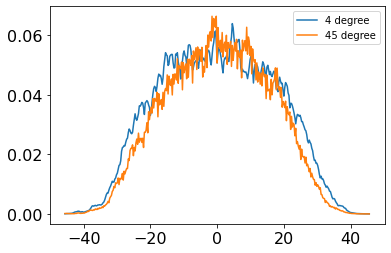

In [11]:
# COMPUTE AVERAGE OVER THE SUPPLEMENTARY ANGLES (THIS IS BASED ON THE SYMMETRY IN THE TRANSVERSE PLANE)
avg['theta_new'] = avg['theta'].apply(lambda x: min(x,180-x))

avg_supplementangle = avg.groupby(['new_theta','b'])[['averageN','err']].mean().reset_index()

"""TO SEE HOW PROFILE LOOKS FOR A GIVEN RANGE IN ANGLE [0-5] (here)"""
plt.plot(avg.b[avg.theta==4],avg.averageN[avg.theta ==4], label = "4 degree")
plt.plot(avg.b[avg.theta==45],avg.averageN[avg.theta ==45], label = "45 degree")

plt.legend()

# NOTE: ITS NOT NORMALIZED YET
avg_supplementangle.to_csv(f'{dir_}/NormFolder/NormFolderY{0}r{r}/AvgSupplAngleY{Y}r{r}.txt', sep=' ', index=False)


In [12]:
avg_supplementangle

,new_theta,b,averageN,err
0,0.0,-45.6120,0.000056,0.000054
1,0.0,-45.3586,0.000057,0.000041
2,0.0,-45.1052,0.000053,0.000026
3,0.0,-44.8518,0.000070,0.000054
4,0.0,-44.5984,0.000089,0.000044
...,...,...,...,...
32846,90.0,44.5984,0.000014,0.000011
32847,90.0,44.8518,0.000012,0.000010
32848,90.0,45.1052,0.000011,0.000008
32849,90.0,45.3586,0.000009,0.000007


# NO BINNING IN ANGLE

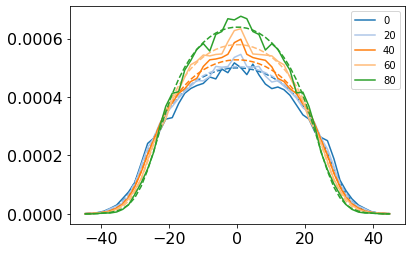

In [14]:
list_Rtheta = []

# GET GROUP OVER ANGLE -- 
avg_angle = avg_supplementangle.groupby('new_theta')

colors = plt.cm.tab20(np.linspace(0, 1, 20))

for angle in range(0,91):
    
    data = avg_angle.get_group(angle)
    bins = pd.qcut(data[data.columns[1]],q=50)

    
    # binning over b
#     df = pd.DataFrame(data.groupby(bins).agg("mean",{1}))

    df = pd.DataFrame(data.groupby(bins).agg(
        b=('b', 'mean'),
        averageN=('averageN', 'mean'),
        err=('err', lambda x: np.sqrt(np.sum(np.square(x)) / len(x)))
    ))
        
    from scipy.interpolate import interp1d
    
    interp = interp1d( df['b'],df['averageN'], bounds_error=False, fill_value=0)
    normalization_integrand= lambda b: 2*np.pi*b*interp(b)

    norm = scipy.integrate.quad(normalization_integrand,0,np.inf)[0]
    df['averageN'] = df['averageN']/norm
    df['err'] = df['err']/norm
    
    # ***NORMALIZING THE OUTPUT DATA HERE***
    final_norm=norm 
    avg_supplementangle.averageN[avg_supplementangle.new_theta==angle]/=final_norm
    avg_supplementangle.err[avg_supplementangle.new_theta==angle]/=final_norm


    vcurve = np.vectorize(func)

    popt, pcov = scipy.optimize.curve_fit(vcurve, df['b'], df['averageN'], 
                                          sigma=df['err'], absolute_sigma=True, p0=[6*FMGEV])
    
    list_Rtheta.append((angle*3.14/180, *popt, np.sqrt(np.diag(pcov))[0]))
    
    if angle%20==0:
        color = colors[int(angle/20)]
        plt.plot(df['b'], df['averageN'], color=color, label=f'{angle}')
        plt.plot(df['b'], vcurve(df['b'], *popt), color=color, linestyle="dashed")

        plt.legend()

In [15]:
pd.DataFrame(list_Rtheta)
df_Rtheta = pd.DataFrame(list_Rtheta)
df_Rtheta.columns = ['AngleinRadian', 'Rtheta', 'Rtheta_err']

In [16]:
df_Rtheta

,AngleinRadian,Rtheta,Rtheta_err
0,0.000000,29.644763,0.187012
1,0.017444,30.130542,0.155221
2,0.034889,30.300075,0.147283
3,0.052333,30.411568,0.141492
4,0.069778,30.520850,0.137100
...,...,...,...
86,1.500222,26.141753,0.216695
87,1.517667,26.222384,0.221511
88,1.535111,26.162811,0.225721
89,1.552556,26.076737,0.231243


[0.04898412 0.01269865 0.01648223 0.00814977]
R is 5.424050821418788 fm; b2 is 0.14058356573862343 ; b3 is 0.060529425531479816; b4 is -0.03561173740852582


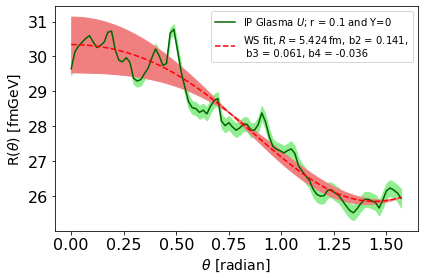

In [17]:
import scipy
import scipy.special as sp

def sp_hrm(l, m, theta):
    """angle in radian"""
    return sp.sph_harm(m, l, 0, theta) 


def Rtheta(theta, R, b2, b3, b4):
    return R * ( 1 + b2 * np.real(sp_hrm(2, 0, theta)) + b3 * np.real(sp_hrm(3, 0, theta)) \
                + b4 * np.real(sp_hrm(4, 0, theta)))


vcurve = np.vectorize(Rtheta)


popt, pcov = scipy.optimize.curve_fit(vcurve, df_Rtheta[df_Rtheta.columns[0]], \
                       df_Rtheta[df_Rtheta.columns[1]], p0=[6*FMGEV, 0.2,0,0.05],\
                                     sigma=df_Rtheta['Rtheta_err'], absolute_sigma=True)

error_final = np.sqrt(np.diag(pcov))
print(error_final)

plt.plot(df_Rtheta[df_Rtheta.columns[0]], df_Rtheta[df_Rtheta.columns[1]]\
         ,color="darkgreen", label="IP Glasma $U$; " + f'r = {r}' + " and " f'Y={Y}')  


plt.fill_between(df_Rtheta['AngleinRadian'], df_Rtheta['Rtheta']-df_Rtheta['Rtheta_err'], df_Rtheta['Rtheta']+df_Rtheta['Rtheta_err']
         ,color="lightgreen")  

plt.plot(df_Rtheta[df_Rtheta.columns[0]], vcurve(df_Rtheta[df_Rtheta.columns[0]], *popt),\
         linestyle="dashed", color="red",label = "WS fit, $R=" + str(round(popt[0]/FMGEV,3)) + \
         r"\,\mathrm{fm}$, b2 = "+ str(round(popt[1],3)) + ",\n b3 = "+ str(round(popt[2],3)) \
         + ", b4 = "+ str(round(popt[3],3)))

plt.fill_between(df_Rtheta[df_Rtheta.columns[0]],vcurve(df_Rtheta[df_Rtheta.columns[0]], *(popt - error_final))\
                 , vcurve(df_Rtheta[df_Rtheta.columns[0]], *(popt + error_final)) ,color="lightcoral")

plt.legend()

print(f'R is {popt[0]/FMGEV} fm; b2 is {popt[1]} ; b3 is {popt[2]}; b4 is {popt[3]}'.format({popt[0]/FMGEV},{popt[1]},\
                                                                                         {popt[2]},{popt[3]}))
plt.xlabel(r'$\theta$' + " [radian]", fontsize=14)
plt.ylabel(r'R($\theta$) [fmGeV]', fontsize=14)
plt.tight_layout()
plt.savefig(f'{dir_}/PLOTS/Y{Y}r{r}.pdf')

with open(f'{dir_}/StepFitValues.txt', 'a') as file:
    file.write('\n')
    file.write(f'{Y} {r} {popt[0]/FMGEV:.6f} {error_final[0]:.6f} {popt[1]:.6f} {error_final[1]:.6f} \
    {popt[2]:.6f} {error_final[2]:.6f} {popt[3]:.6f} {error_final[3]:.6f} ')


### NOTE

func_withRtheta AND func ARE SIMILAR but differs from avg_supplementangle (dataset) BY A FACTOR OF "2"

def func(b, R):

    return scipy.integrate.quad(integrand, -np.inf, np.inf, args=(b, R))[0]

def func_withRtheta(b, theta):

    return scipy.integrate.quad(integrand_withRtheta, -np.inf, np.inf, args=(b, theta))[0]
